In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import datetime
import math
import gc

In [3]:
import gc
gc.collect()

0

In [5]:
print("start")
data_path = '/Users/yzh/Desktop/R data/kkbox/'
trainx = pd.read_csv(data_path + 'train.csv', dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                  'source_screen_name' : 'category',
                                                  'source_type' : 'category',
                                                  'target' : np.uint8,
                                                  'song_id' : 'category'})
members = pd.read_csv(data_path + 'members.csv',dtype={'city' : 'category',
                                                      'bd' : np.uint8,
                                                      'gender' : 'category',
                                                      'registered_via' : 'category'},
                     parse_dates=['registration_init_time','expiration_date'])
songs_extra = pd.read_csv(data_path + 'song_extra_info.csv')
songs = pd.read_csv(data_path + 'songs.csv',dtype={'genre_ids': 'category',
                                                  'language' : 'category',
                                                  'artist_name' : 'category',
                                                  'composer' : 'category',
                                                  'lyricist' : 'category',
                                                  'song_id' : 'category'})
train=trainx[0:5500000];test=trainx[5500000:7477418]
print("finished")

start


finished


In [6]:
print('Data merging...')


train = train.merge(songs, on='song_id', how='left')
test = test.merge(songs, on='song_id', how='left')

members['membership_days'] = members['expiration_date'].subtract(members['registration_init_time']).dt.days.astype(int)

members['registration_year'] = members['registration_init_time'].dt.year
members['registration_month'] = members['registration_init_time'].dt.month
members['registration_date'] = members['registration_init_time'].dt.day

members['expiration_year'] = members['expiration_date'].dt.year
members['expiration_month'] = members['expiration_date'].dt.month
members['expiration_date'] = members['expiration_date'].dt.day
members = members.drop(['registration_init_time'], axis=1)

def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan
        
songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)
songs_extra.drop(['isrc', 'name'], axis = 1, inplace = True)

train = train.merge(members, on='msno', how='left')
test = test.merge(members, on='msno', how='left')

train = train.merge(songs_extra, on = 'song_id', how = 'left')
train.song_length.fillna(200000,inplace=True)
train.song_length = train.song_length.astype(np.uint32)
train.song_id = train.song_id.astype('category')


test = test.merge(songs_extra, on = 'song_id', how = 'left')
test.song_length.fillna(200000,inplace=True)
test.song_length = test.song_length.astype(np.uint32)
test.song_id = test.song_id.astype('category')

# import gc
# del members, songs; gc.collect();

print('Done merging...')

Data merging...


Done merging...


In [7]:
print ("Adding new features")

def genre_id_count(x):
    if x == 'no_genre_id':
        return 0
    else:
        return x.count('|') + 1

train['genre_ids'].fillna('no_genre_id',inplace=True)
test['genre_ids'].fillna('no_genre_id',inplace=True)
train['genre_ids_count'] = train['genre_ids'].apply(genre_id_count).astype(np.int8)
test['genre_ids_count'] = test['genre_ids'].apply(genre_id_count).astype(np.int8)

def lyricist_count(x):
    if x == 'no_lyricist':
        return 0
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1
    return sum(map(x.count, ['|', '/', '\\', ';']))

train['lyricist'].fillna('no_lyricist',inplace=True)
test['lyricist'].fillna('no_lyricist',inplace=True)
train['lyricists_count'] = train['lyricist'].apply(lyricist_count).astype(np.int8)
test['lyricists_count'] = test['lyricist'].apply(lyricist_count).astype(np.int8)

def composer_count(x):
    if x == 'no_composer':
        return 0
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1

train['composer'].fillna('no_composer',inplace=True)
test['composer'].fillna('no_composer',inplace=True)
train['composer_count'] = train['composer'].apply(composer_count).astype(np.int8)
test['composer_count'] = test['composer'].apply(composer_count).astype(np.int8)

def is_featured(x):
    if 'feat' in str(x) :
        return 1
    return 0

train['artist_name'].fillna('no_artist',inplace=True)
test['artist_name'].fillna('no_artist',inplace=True)
train['is_featured'] = train['artist_name'].apply(is_featured).astype(np.int8)
test['is_featured'] = test['artist_name'].apply(is_featured).astype(np.int8)

def artist_count(x):
    if x == 'no_artist':
        return 0
    else:
        return x.count('and') + x.count(',') + x.count('feat') + x.count('&')

train['artist_count'] = train['artist_name'].apply(artist_count).astype(np.int8)
test['artist_count'] = test['artist_name'].apply(artist_count).astype(np.int8)

# if artist is same as composer
train['artist_composer'] = (train['artist_name'] == train['composer']).astype(np.int8)
test['artist_composer'] = (test['artist_name'] == test['composer']).astype(np.int8)


# if artist, lyricist and composer are all three same
train['artist_composer_lyricist'] = ((train['artist_name'] == train['composer']) & (train['artist_name'] == train['lyricist']) & (train['composer'] == train['lyricist'])).astype(np.int8)
test['artist_composer_lyricist'] = ((test['artist_name'] == test['composer']) & (test['artist_name'] == test['lyricist']) & (test['composer'] == test['lyricist'])).astype(np.int8)

# is song language 17 or 45. 
def song_lang_boolean(x):
    if '17.0' in str(x) or '45.0' in str(x):
        return 1
    return 0

train['song_lang_boolean'] = train['language'].apply(song_lang_boolean).astype(np.int8)
test['song_lang_boolean'] = test['language'].apply(song_lang_boolean).astype(np.int8)


_mean_song_length = np.mean(train['song_length'])
def smaller_song(x):
    if x < _mean_song_length:
        return 1
    return 0

train['smaller_song'] = train['song_length'].apply(smaller_song).astype(np.int8)
test['smaller_song'] = test['song_length'].apply(smaller_song).astype(np.int8)
print("done")

Adding new features


done


In [8]:
print("then adding magic play_ratio")
lentrain=len(train['song_id']);lentest=len(test['song_id'])

_dict_ratio_composer_played_train = {k: v for k, 
                v in ( train['composer'].value_counts()/len(train['composer']) ).iteritems() }
_dict_ratio_composer_played_test = {k: v for k, 
                v in ( test['composer'].value_counts()/len(test['composer']) ).iteritems() }
def ratio_composer_played_train(x): 
     if x=="no_composer" or x=="佚名":
        return 0.5/(lentrain)+0.5/lentest
     else:  
      try:
        return 0.5*_dict_ratio_composer_played_train[x]+0.5*_dict_ratio_composer_played_test[x]
      except KeyError:
        return _dict_ratio_composer_played_train[x]

def ratio_composer_played_test(x):
    if x=="no_composer" or x=="佚名":
         return 0.5/(lentrain)+0.5/lentest
    else:
      try:
        return 0.5*_dict_ratio_composer_played_train[x]+0.5*_dict_ratio_composer_played_test[x]
      except KeyError:
        return _dict_ratio_composer_played_test[x]

train['ratio_composer_played'] = train['composer'].apply(ratio_composer_played_train).astype(np.float64)
test['ratio_composer_played'] = test['composer'].apply(ratio_composer_played_test).astype(np.float64)
#######
_dict_ratio_artist_played_train = {k: v for k, 
                v in ( train['artist_name'].value_counts()/len(train['artist_name']) ).iteritems() }
_dict_ratio_artist_played_test = {k: v for k, 
                v in ( test['artist_name'].value_counts()/len(test['artist_name']) ).iteritems() }
def ratio_artist_played_train(x):
     if x=="no_artist" or x=="Various Artists" or x=="群星" or x=="佚名":
         return 0.5/(lentrain)+0.5/lentest
     else:
      try:
        return 0.5*_dict_ratio_artist_played_train[x]+0.5*_dict_ratio_artist_played_test[x]
      except KeyError:
        return _dict_ratio_artist_played_train[x]

def ratio_artist_played_test(x):
     if x=="no_artist" or x=="Various Artists" or x=="群星" or x=="佚名":
         return 0.5/(lentrain)+0.5/lentest
     else:
      try:
        return 0.5*_dict_ratio_artist_played_train[x]+0.5*_dict_ratio_artist_played_test[x]
      except KeyError:
        return _dict_ratio_artist_played_test[x]

train['ratio_artist_played'] = train['artist_name'].apply(ratio_artist_played_train).astype(np.float64)
test['ratio_artist_played'] = test['artist_name'].apply(ratio_artist_played_test).astype(np.float64)


# In[ ]:

_dict_ratio_song_played_train = {k: v for k, 
                v in ( train['song_id'].value_counts()/len(train['song_id']) ).iteritems() }
_dict_ratio_song_played_test = {k: v for k, 
                v in ( test['song_id'].value_counts()/len(test['song_id']) ).iteritems() }
def ratio_song_played_train(x):
  if x==np.nan:
      return 0.5/(lentrain)+0.5/lentest
  else:
    try:
      return 0.5*_dict_ratio_song_played_train[x]+\
             0.5*_dict_ratio_song_played_test[x]
    except KeyError:
      return _dict_ratio_song_played_train[x]

def ratio_song_played_test(x):
  if x==np.nan:
      return 0.5/(lentrain)+0.5/lentest
  else:
    try:
      return 0.5*_dict_ratio_song_played_train[x]\
             +0.5*_dict_ratio_song_played_test[x]
    except KeyError:
      return _dict_ratio_song_played_test[x]

train['ratio_song_played'] = train['song_id'].apply(ratio_song_played_train).astype(np.float64)
test['ratio_song_played'] = test['song_id'].apply(ratio_song_played_test).astype(np.float64)


# In[186]:

#songs['artist_name'].value_counts()/len(train['artist_name'])


print(" adding genre&lyricist ratio")
_dict_ratio_genre_played_train = {k: v for k, 
                v in ( train['genre_ids'].value_counts()/len(train['genre_ids']) ).iteritems() }
_dict_ratio_genre_played_test = {k: v for k, 
                v in ( test['genre_ids'].value_counts()/len(test['genre_ids']) ).iteritems() }
def ratio_genre_played_train(x):
    if x=="no_genre_id":
      return 0.5/(lentrain)+0.5/lentest
    else:
     try:
       return 0.5*_dict_ratio_genre_played_train[x]+0.5*_dict_ratio_genre_played_test[x]
     except KeyError:
       return _dict_ratio_genre_played_train[x]

def ratio_genre_played_test(x):
    if x=="no_genre_id":
      return 0.5/(lentrain)+0.5/lentest
    else:
      try:
        return 0.5*_dict_ratio_genre_played_train[x]+0.5*_dict_ratio_genre_played_test[x]
      except KeyError:
        return _dict_ratio_genre_played_test[x]

train['ratio_genre_played'] = train['genre_ids'].apply(ratio_genre_played_train).astype(np.float64)
test['ratio_genre_played'] = test['genre_ids'].apply(ratio_genre_played_test).astype(np.float64)

############
_dict_ratio_lyricist_played_train = {k: v for k, 
                v in ( train['lyricist'].value_counts()/len(train['lyricist']) ).iteritems() }
_dict_ratio_lyricist_played_test = {k: v for k, 
                v in ( test['lyricist'].value_counts()/len(test['lyricist']) ).iteritems() }
def ratio_lyricist_played_train(x):
     if x=="no_lyricist" or x=="佚名":
         return 0.5/(lentrain)+0.5/lentest
     else:
        try:
          return 0.5*_dict_ratio_lyricist_played_train[x]+0.5*_dict_ratio_lyricist_played_test[x]
        except KeyError:
          return _dict_ratio_lyricist_played_train[x]

def ratio_lyricist_played_test(x):
    if x=="no_lyricist" or x=="佚名":
         return 0.5/(lentrain)+0.5/lentest
    else:
      try:
        return 0.5*_dict_ratio_lyricist_played_train[x]+0.5*_dict_ratio_lyricist_played_test[x]
      except KeyError:
        return _dict_ratio_lyricist_played_test[x]

train['ratio_lyricist_played'] = train['lyricist'].apply(ratio_lyricist_played_train).astype(np.float64)
test['ratio_lyricist_played'] = test['lyricist'].apply(ratio_lyricist_played_test).astype(np.float64)
print("done")

then adding magic play_ratio


 adding genre&lyricist ratio


done


train['ratio_artist_played'].corr(train['target']) #upper prop

test['ratio_artist_played'].corr(test['target'])

train['ratio_lyricist_played'].corr(train['target'])

test['ratio_lyricist_played'].corr(train['target'])

more accurate proportion??0.685
more accurate upper proportion??0.6912
full prop 0.15890015868577767 0.12733285449018938
upper prop:0.15888965375085956 0.14471178091031606
lower prop:0.15882986539655755 0.12711725891466466
0.5:0.16163555201226557  0.15029669049335478
0.25:0.16089269456916425 0.14948164729470462
artist:0.048574596817506109 0.041379147614896923
count_art:0.052927608864952173 0.00054284957540948219
artist na:0.077896916772339647 0.056191044723173114
artist 1: almost same, a little bit good

train['user_artist']=(train['msno'].astype(object)+train['artist_name'].astype(object)).astype('category')
test['user_artist']=(test['msno'].astype(object)+test['artist_name'].astype(object)).astype('category')

train['user_genre']=(train['msno'].astype(object)+train['genre_ids'].astype(object)).astype('category')
test['user_genre']=(test['msno'].astype(object)+test['genre_ids'].astype(object)).astype('category')

# number of times the artist has been played
_dict_count_artist_played_train = {k: v for k, v in train['artist_name'].value_counts().iteritems()}
_dict_count_artist_played_test = {k: v for k, v in test['artist_name'].value_counts().iteritems()}
def count_artist_played(x):
    try:
        return _dict_count_artist_played_train[x]
    except KeyError:
        try:
            return _dict_count_artist_played_test[x]
        except KeyError:
            return 0

train['count_artist_played'] = train['artist_name'].apply(count_artist_played).astype(np.int64)
test['count_artist_played'] = test['artist_name'].apply(count_artist_played).astype(np.int64)


print("Done adding features")

dict_num_songs_of_artist={k: v for k, v in (songs['artist_name'].value_counts()/len(songs['artist_name'])).iteritems()}
def num_songs_of_artist(x):
    if x=="no_artist":
        return 0
    else:
        try:
          return dict_num_songs_of_artist[x]
        except KeyError:
          return 0
train['num_songs_of_artist'] = train['artist_name'].apply(num_songs_of_artist).astype(np.float64)
test['num_songs_of_artist'] = test['artist_name'].apply(num_songs_of_artist).astype(np.float64)
print("done")

In [ ]:
train.drop(['uni_art', 'artist_habit','user_play'], axis = 1, inplace = True)
test.drop(['uni_art', 'artist_habit','user_play'], axis = 1, inplace = True)

In [9]:
a=pd.concat([train,test]).groupby("msno",as_index=False).agg({"artist_name":{"uni_art":pd.Series.nunique, #a is for user's play info
                                                                           "user_play":"count"}})
a.columns=a.columns.droplevel(level=0)
a=a.rename(columns={"":"msno"})
train=train.merge(a, on="msno", how="left")
test=test.merge(a, on="msno", how="left")
train["artist_habit"]=train["uni_art"]/train["user_play"]
test["artist_habit"]=test["uni_art"]/test["user_play"]

In [10]:
user_aritst_count=pd.concat([train,test]).groupby(["msno","artist_name"],as_index=False).agg({"song_id":{"user_artist_count":"count"}})

In [11]:
user_aritst_count.columns=user_aritst_count.columns.droplevel(level=0) # user_aritst_count is used again?

In [12]:
user_aritst_count.columns.values[0]="msno"   
user_aritst_count.columns.values[1]="artist_name"

In [13]:
train=train.merge(user_aritst_count, on=["msno","artist_name"], how="left")
test=test.merge(user_aritst_count, on=["msno", "artist_name"],how="left")
train["coolartist_like"]=train["user_artist_count"]/train["user_play"]
test["coolartist_like"]=test["user_artist_count"]/test["user_play"]

In [14]:
user_language_count=pd.concat([train,test]).groupby(["msno","language"],as_index=False).agg({"song_id":{"cooluser_language_count":"count"}})

In [15]:
user_language_count.columns=user_language_count.columns.droplevel(level=0)
user_language_count.columns.values[0]="msno"
user_language_count.columns.values[1]="language"

In [16]:
train=train.merge(user_language_count, on=["msno","language"], how="left")
test=test.merge(user_language_count, on=["msno", "language"],how="left")
train["coollangu_like"]=train["cooluser_language_count"]/train["user_play"]
test["coollangu_like"]=test["cooluser_language_count"]/test["user_play"]

In [17]:
unique_genre=pd.concat([train,test]).groupby("msno",
            as_index=False).agg({"genre_ids":{"cooluni_genre":pd.Series.nunique}})
unique_genre.columns=unique_genre.columns.droplevel(level=0)
unique_genre=unique_genre.rename(columns={"":"msno"})
train=train.merge(unique_genre, on="msno", how="left")
test=test.merge(unique_genre, on="msno", how="left")
train["coolgenre_habit"]=train["cooluni_genre"]/train["user_play"]
test["coolgenre_habit"]=test["cooluni_genre"]/test["user_play"]

In [18]:
user_genre_count=pd.concat([train,test]).groupby(["msno",
"genre_ids"],as_index=False).agg({"song_id":{"cooluser_genre_count":"count"}})
user_genre_count.columns=user_genre_count.columns.droplevel(level=0)
user_genre_count.columns.values[0]="msno"
user_genre_count.columns.values[1]="genre_ids"
train=train.merge(user_genre_count, on=["msno","genre_ids"], how="left")
test=test.merge(user_genre_count, on=["msno", "genre_ids"],how="left")
train["coolgenre_like"]=train["cooluser_genre_count"]/train["user_play"]
test["coolgenre_like"]=test["cooluser_genre_count"]/test["user_play"]

In [19]:
user_lyri_count=pd.concat([train,test]).groupby(["msno",
"lyricist"],as_index=False).agg({"song_id":{"cooluser_lyri_count":"count"}})
user_lyri_count.columns=user_lyri_count.columns.droplevel(level=0)
user_lyri_count.columns.values[0]="msno"
user_lyri_count.columns.values[1]="lyricist"
train=train.merge(user_lyri_count, on=["msno","lyricist"], how="left")
test=test.merge(user_lyri_count, on=["msno", "lyricist"],how="left")
train["coollyri_like"]=train["cooluser_lyri_count"]/train["user_play"]
test["coollyri_like"]=test["cooluser_lyri_count"]/test["user_play"]

In [20]:
user_compo_count=pd.concat([train,test]).groupby(["msno",
"composer"],as_index=False).agg({"song_id":{"cooluser_compo_count":"count"}})
user_compo_count.columns=user_compo_count.columns.droplevel(level=0)
user_compo_count.columns.values[0]="msno"
user_compo_count.columns.values[1]="composer"
train=train.merge(user_compo_count, on=["msno","composer"], how="left")
test=test.merge(user_compo_count, on=["msno", "composer"],how="left")
train["coolcompo_like"]=train["cooluser_compo_count"]/train["user_play"]
test["coolcompo_like"]=test["cooluser_compo_count"]/test["user_play"]

In [21]:
user_leng_count=pd.concat([train,test]).groupby(["msno"],
    as_index=False).agg({"song_length":{"cooluser_length_mean":"mean"}})

In [ ]:
user_leng_count.columns=user_leng_count.columns.droplevel(level=0)
user_leng_count.columns.values[0]="msno"
train=train.merge(user_leng_count, on="msno", how="left")
test=test.merge(user_leng_count, on="msno",how="left")
train["coolleng_like"]=train["song_length"]/train["cooluser_length_mean"]
test["coolleng_like"]=test["song_length"]/test["cooluser_length_mean"]

In [ ]:
user_year_count=pd.concat([train,test]).groupby(["msno"],
    as_index=False).agg({"song_year":{"cooluser_year_mean":pd.Series.mean}})

In [24]:
user_year_count.columns=user_year_count.columns.droplevel(level=0)
user_year_count.columns.values[0]="msno"
train=train.merge(user_year_count, on="msno", how="left")
test=test.merge(user_year_count, on="msno",how="left")
train["coolyear_like"]=train["song_year"]-train["cooluser_year_mean"]
test["coolyear_like"]=test["song_year"]-test["cooluser_year_mean"]

In [24]:
def convert(x):
    if x==0:
        return np.nan
    else:
        return x
train["bd2"]=train["bd"].apply(convert).astype(np.float64)
test["bd2"]=test["bd"].apply(convert).astype(np.float64)

In [25]:
gc.collect()

587

In [26]:
song_bd_mean=pd.concat([train,test]).groupby(["song_id"],
    as_index=False).agg({"bd2":{"coolsong_bd_mean":pd.Series.mean},
                         "msno":{"coolsong_play":"count"}})

In [27]:
song_bd_mean.dtypes

song_id                       object
msno     coolsong_play         int64
bd2      coolsong_bd_mean    float64
dtype: object

In [28]:
song_bd_mean.columns=song_bd_mean.columns.droplevel(level=0)
song_bd_mean.columns.values[0]="song_id"
train=train.merge(song_bd_mean, on="song_id", how="left")
test=test.merge(song_bd_mean, on="song_id",how="left")
train["coolbd_like"]=train["bd2"]-train["coolsong_bd_mean"]
test["coolbd_like"]=test["bd2"]-test["coolsong_bd_mean"]

In [42]:
song_gender_count=pd.concat([train,test]).groupby(["song_id",
"gender"],as_index=False).agg({"msno":{"coolsong_gender_count":"count"}})
song_gender_count.columns=song_gender_count.columns.droplevel(level=0)
song_gender_count.columns.values[0]="song_id"
song_gender_count.columns.values[1]="gender"
train=train.merge(song_gender_count, on=["song_id","gender"], how="left")
test=test.merge(song_gender_count, on=["song_id", "gender"],how="left")
train["coolgender_like"]=train["coolsong_gender_count"]/train["coolsong_play"]
test["coolgender_like"]=test["coolsong_gender_count"]/test["coolsong_play"]

In [1]:
print(song_bd_mean)

NameError: name 'song_bd_mean' is not defined

In [43]:
user_info=pd.read_csv('/Users/yzh/Downloads/user_logs_final.csv')

In [45]:
train = train.merge(user_info, on='msno', how='left')
test = test.merge(user_info, on='msno', how='left')

In [51]:
gc.collect()

0

train['user_habit']=(train['num_25']+train['num_50']+train['num_985']+train['num_100']+train['days_listened']+train['total_secs'])/5
test['user_habit']=(test['num_25']+test['num_50']+test['num_985']+test['num_100']+test['days_listened']+test['total_secs'])/5

In [48]:
print ("Train test and validation sets")
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')


X_train = train.drop(['target','bd'], axis=1)
y_train = train['target'].values
X_valid = test.drop(['target','bd'], axis=1)
y_valid = test['target'].values
print('Processed data...')

Train test and validation sets


Processed data...


for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')
for col in test.columns:
    if test[col].dtype == object:
        test[col] = test[col].astype('category')

In [50]:
d_train_final = lgb.Dataset(X_train, y_train,max_bin=256)
watchlist_final = lgb.Dataset(X_valid, y_valid,max_bin=256)

In [52]:
print("start modelx")
params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting': 'dart',
        'learning_rate': 0.3 ,
        'verbose': 0,
        'num_leaves':300,
        'num_rounds': 200,
        'metric' : 'auc'
    }

model_f2 = lgb.train(params, train_set=d_train_final,  valid_sets=watchlist_final, verbose_eval=3)

start modelx


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/lightgbm/basic.py:648: LGBMDeprecationWarning: The `max_bin` parameter is deprecated and will be removed in 2.0.12 version. Please use `params` to pass this parameter.
  'Please use `params` to pass this parameter.', LGBMDeprecationWarning)


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/lightgbm/basic.py:642: UserWarning: max_bin keyword has been found in `params` and will be ignored. Please use max_bin argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/lightgbm/basic.py:671: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


[3]	valid_0's auc: 0.678489


[6]	valid_0's auc: 0.688866


[9]	valid_0's auc: 0.693416


[12]	valid_0's auc: 0.696918


[15]	valid_0's auc: 0.700688


[18]	valid_0's auc: 0.703458


[21]	valid_0's auc: 0.70523


[24]	valid_0's auc: 0.706287


[27]	valid_0's auc: 0.70738


[30]	valid_0's auc: 0.707419


[33]	valid_0's auc: 0.70798


[36]	valid_0's auc: 0.708035


[39]	valid_0's auc: 0.708384


[42]	valid_0's auc: 0.708784


[45]	valid_0's auc: 0.70889


[48]	valid_0's auc: 0.709168


[51]	valid_0's auc: 0.709244


[54]	valid_0's auc: 0.709068


[57]	valid_0's auc: 0.709472


[60]	valid_0's auc: 0.709602


[63]	valid_0's auc: 0.709816


[66]	valid_0's auc: 0.709901


[69]	valid_0's auc: 0.70999


[72]	valid_0's auc: 0.710161


[75]	valid_0's auc: 0.710269


[78]	valid_0's auc: 0.710253


[81]	valid_0's auc: 0.710191


[84]	valid_0's auc: 0.710426


[87]	valid_0's auc: 0.710375


[90]	valid_0's auc: 0.710444


[93]	valid_0's auc: 0.710437


[96]	valid_0's auc: 0.71055


[99]	valid_0's auc: 0.710347


[102]	valid_0's auc: 0.710242


[105]	valid_0's auc: 0.710265


[108]	valid_0's auc: 0.710208


[111]	valid_0's auc: 0.710361


[114]	valid_0's auc: 0.710444


[117]	valid_0's auc: 0.710425


[120]	valid_0's auc: 0.710448


[123]	valid_0's auc: 0.710497


[126]	valid_0's auc: 0.710539


[129]	valid_0's auc: 0.7104


[132]	valid_0's auc: 0.710401



KeyboardInterrupt



# no expiration_year: round90 0.682588 not good
# 300 leaves dart, no deal with overfitting,no source_system_tab, round84: 0.683639
# 300 leaves dart, no deal with overfitting,ratio_song_played: round 54: 0.690083(LB public:0.68982)
# 300 leaves dart, no deal with overfitting,ratio_song_played, test0.75 : round 111: 0.689802(not stable)
# 300 leaves dart, no deal with overfitting,ratio_song_played, test0.75, train 0.75 round 51: 0.691717
# 300 leaves dart, no deal with overfitting,ratio_song_played,  train 0.75 round51 :0.692153
# 300 leaves dart, no deal with overfitting, ratio: composer,artist,song, test0.75, train 0.75 round90: 0.691855
# 300 leaves dart, no deal with overfitting, ratio: compo,artist,song,genre,lyri test0.75, train 0.75 round99: 0.691943  ?[99]0.691461
?directly put na: result just so so about 0.6918
?deal with missing value of some things like  "no_artist..", 0.69
?deal with missing value of some things like  "no_artist.." and add num_song_artist:not very good
?delete some online features, 0.69
300 leaves dart, no deal with overfitting,ratio: cleaned artist,song,0.6912
300 leaves dart, no deal with overfitting,ratio: song, no artist 0.6911
300 leaves dart, no deal with overfitting,ratio: song, ratio_artist not good

0.5:
300 leaves dart, no deal with overfitting,ratio: song, ratio_artist 99 0.6922
300 leaves dart, no deal with overfitting,ratio: song,51: 0.692179   [111]0.692341  LB:0.6916
+user_artist: [96]	valid_0's auc: 0.693059 LB 0.69110
+user_artist -artist_name   direct LB, round96: 0.69119
+user_artist,user_genre [111]	0.6927
+user_artist,user_genre -genre_ids  [84]0.693366 LB.069057  LB:0.69201(use 250leave 0.1learn 396round)
+user_artist,user_genre -genre_ids -artist[90]	valid_0's auc: 0.692811
+artist_gender:not  good   [111]	valid_0's auc: 0.692113
+churn  maybe[84]	valid_0's auc: 0.695015 LB:0.69248
+total_secs  [96]	valid_0's auc: 0.694918
+average churn [102]	stop valid_0's auc: 0.69379 not good
+churn,song_bd [81]	stopvalid_0's auc: 0.694346 not good
250leaves rate0.1 round at [402]	valid_0's auc: 0.695759
+churn, country: [96]	valid_0's auc: 0.694806 
+total_secs  	leave250 rate0.1 deal with overfitting [1668] 0.693562    not good     bin500 [75]	valid_0's auc: 0.69521    bin1500 stop at[75]	valid_0's auc: 0.694869
+total_secs +simple artist_habit[150]	valid_0's auc: 0.695732
+total_secs +strict artist_habit [159]	valid_0's auc: 0.696162

In [55]:
gain = model_f2.feature_importance('gain')
ft = pd.DataFrame({'feature':model_f2.feature_name(), 'split':model_f2.feature_importance('split'), 
                   'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
ft

,feature,gain,split
0,msno,60.297363,33091
4,source_type,11.704171,280
34,ratio_song_played,7.232598,583
7,artist_name,5.200464,3607
1,song_id,4.702336,3594
40,user_artist_count,2.690039,482
42,cooluser_language_count,1.887774,333
3,source_screen_name,1.464338,264
8,composer,1.249942,1217
2,source_system_tab,0.727190,104


remove artist_composer_lyricist, artist_composer, ratio_lyricist_played, lyricist_count, genre_ids_count, composer_count,smaller_song, is_featured, artist_count, 

In [108]:
corr_df.dtypes

target                        uint8
song_length                  uint32
bd                            uint8
expiration_date               int64
membership_days               int64
registration_year             int64
registration_month            int64
registration_date             int64
expiration_year               int64
expiration_month              int64
song_year                   float64
genre_ids_count                int8
lyricists_count                int8
composer_count                 int8
is_featured                    int8
artist_count                   int8
artist_composer                int8
artist_composer_lyricist       int8
song_lang_boolean              int8
smaller_song                   int8
ratio_composer_played       float64
ratio_artist_played         float64
ratio_song_played           float64
ratio_genre_played          float64
ratio_lyricist_played       float64
num_songs_of_artist         float64
dtype: object

corr: deal ratio with na and add num_song_artist 

In [23]:
corr_df=train
for col in corr_df.columns:
    if pd.core.common.is_categorical_dtype(corr_df[col]):
        corr_df = corr_df.drop([col], axis=1)

In [31]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [24]:
cor=corr_df.corr()

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
%matplotlib inline

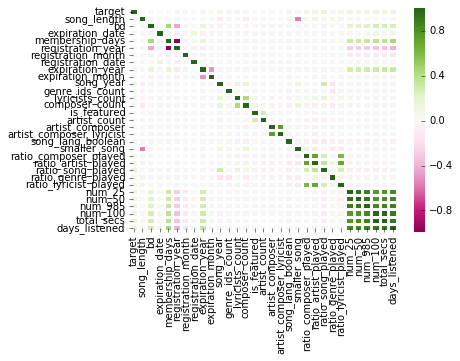

In [26]:
sns.heatmap(cor, xticklabels=cor.columns,yticklabels=cor.columns,linewidths=2,cmap="PiYG")

corr: deal ratio with na and add num_song_artist 

In [55]:
from sklearn.metrics import roc_curve, auc
p_test_2 = model_f2.predict(X_valid)
f,t,x=roc_curve(test['target'].values, p_test_2)
roc_auc = auc(f, t)
print(roc_auc)

0.694589973745


In [54]:
gc.collect()

481